In [1]:
import sys  
sys.path.append('scripts/')
from mcl import *
from kf import * 

In [2]:
class EstimatedLandmark(Landmark):
    '''推定したランドマークの結果を地図上に表示させる。'''
    def __init__(self):
        super().__init__(0,0) 
        self.cov = None #変更
    
    '''共分散がない場合は描画しない'''
    def draw(self, ax, elems): 
        if self.cov is None:
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 10)
        elems.append(ax.add_patch(e))

In [3]:
class MapParticle(Particle):  
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
     
    # 観測１回目
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        '''ロボットがランドマークを初めて観測した場合の処理をする。
        ここでは、推定するランドマークの位置と共分散を初期化する。'''
        # ワールド座標系においてのパーティクルの位置と方角
        x, y, t = self.pose
        # パーティクルとランドマークの距離と方角
        ell, phi = z
        
        '''この観測結果(ランドマークの位置)をワールド座標系(mx, my)に変換する。'''
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y
        
        '''
        ワールド座標系にあるランドマークの位置ｍ(mx,my)を引数にとり、ランドマークからパーティクルまでの距離と方角を出力する観測モデルh(m)を定義
        観測モデルはガウス分布に従うと仮定する。
        h(m)は非線形な関数なので、ガウス分布で表現するためにテイラー展開を用いて線形化する。
        線形化することでカルマンフィルタに適用できるようになる(拡張カルマンフィルタ)。
        線形化に必要なパーティクルとランドマークの距離で偏微分した行列Hを計算する。
        '''
    
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                                [                     (y - my)/ell,                   (mx - x)/ell]])
        
        '''実際の観測結果にはパーティクルとランドマークの距離には雑音を含まれている。雑音を考慮するための行列Qを計算する。'''
        
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))
        
        '''推定するランドマークの共分散と位置の初期値を定義'''
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H))
        landmark.pos = np.array([mx, my]).T
    
    # 観測２回目
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):  ###fastslam7
        '''二回目以降にロボットがランドマークを観測した際の処理を行う。
        　ここでは、前に推定した結果に現在の観測結果を反映させ、推定するランドマークの位置と共分散を更新する'''
        # ワールド座標系においてのパーティクルの位置と方角
        x, y, _ = self.pose
        # 前回推定したワールド座標系においてのランドマークの位置
        mx, my =  landmark.pos
        # ロボットのカメラから観測されたランドマークまでの距離と方角
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos)
        estm_ell, _ = estm_z
        
        '''観測したランドマークが近すぎる場合は更新を行わない。'''
        if estm_ell < 0.01:
            return
        
        
        '''ロボットがランドマークを観測した際、行列HとQを計算する。
        行列HとQの意味はinit_landmark_estimationと同様'''
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        
        '''前回の推定したランドマークの分布と現在の推定したランドマークの分布の中心の変化量を計算する。'''
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ###重みの更新###
        '''計算したHとQを用いて、観測結果を前回のランドマークの共分散に反映させた共分散Q_zを計算'''
        Q_z = H.dot(landmark.cov).dot(H.T) + Q
        '''計算したQ_zを共分散、観測したランドマークの位置を中心としたガウス分布を用いて尤度計算し、重みを更新する。'''
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)
        
        ###ランドマークの推定の更新###
        '''前回の推定したランドマークの共分散と位置を計算したカルマンゲインを用いて、更新する。'''
        landmark.pos = K.dot(z - estm_z) + landmark.pos
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)
        
    def observation_update(self, observation, distance_dev_rate, direction_dev): 
        '''ロボットがランドマークを観測した際、過去の地図情報(ランドマークの位置と共分散)に現在の観測結果を反映させ、地図情報を更新する。
        ランドマークを初めて観測する場合は過去の地図情報がないので、観測した結果から地図情報の初期状態として定義する。'''
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)

In [4]:
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        '''FastSLAMではパーティクルにロボットの位置と重み、地図情報(ランドマークの位置や共分散)をもたせる。'''
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
        
    def observation_update(self, observation):  
        '''ロボットの観測結果を用いて、各パーティクルの重みや地図情報を更新する。'''
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) #self.mapを削除
        '''パーティクル群の中で一番大きい重みのパーティクルを抽出する。'''
        self.set_ml()
        '''抽出したパーティクル付近に各パーティクルを再配置する。'''
        self.resampling() 
        
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

<IPython.core.display.Javascript object>


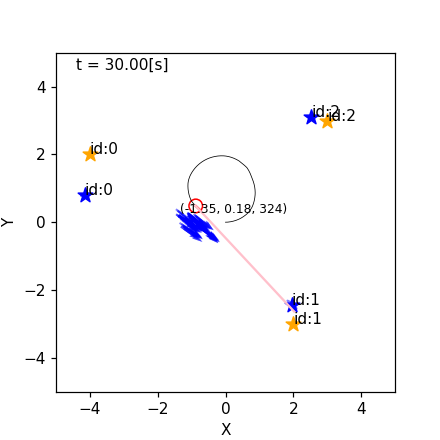

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    pf = FastSlam(100, init_pose, len(m.landmarks))
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [6]:
a.pf.particles[10].map.landmarks[2].cov

In [7]:
math.sqrt(0.0025)

0.05